In [1]:
### PREAMBLE
# "Unsupervised learning&#58; clustering and dimensionality reduction"
# unsupervised.svg

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Unsupervised

Thus far, we have presented machine learning methods largely in the context of _supervised_ learning.  This means we talked about machine learning data sets as having inputs $x$, outputs $y$, and the goal of a machine learning algorithm is to learn how to predict $y$ from $x$.  In my experience, supervised learning does traditionally dominate the majority of practical data science applications, but in this lecture and in a few layer ones, we'll discuss approaches that differ from this.  In particular, in this set of notes we'll consider the setting of unsupervised learning, we are _not_ given corresponding input/output pairs, but where we are _just_ given the inputs $x$.  Of course, this raises the obvious question: if we aren't given a target output, what exactly are we supposed to predict? And indeed, the task of unsupervised learning is ambigous on some level.  However the general philosophy of unsupervised learning is that we want to discover some kind of structure in the data.  Different unsupervised learning methods work in very different ways, and discover very different kinds of structure, but they all have this similar element.

We're going to focus here on first defining unsupervised learning in a generic manner, using the same notions of hypothesis functions, loss functions, and optimization procedures that we used for supervised learning.  It will turn out that despite the very different context, virtually all unsupervised learning methods can also be viewed in this manner.  But naturally, the way we define hypotheses and loss functions will have to change to account for the fact that we no longer have a well-defined target we are trying to fit.  After definite unsupervised learning in this generic context, we'll desribe two particular unsupervised learning algorithms, and illustrate how they fit into this framework: the k-means clustering algorithm, and the principal component analysis (PCA) algorithm.


## An ML framework for unsupervised learning

Recall from our presentations on supervised learnign that the three aspects of a supervised learning algorithm are: 1) a hypothesis function; 2) a loss function; and 3) a method for minimizing the average loss over the training data.  When we transition to the unsupervised setting, it is not clear what these should involve.  How do we define a hypothesis function when there aren't targets to predict?  Similarly how can we define a loss function when there is no target output to compare with.  And although there are different ways of viewing unsupervised learning in this context, the approach that follows can capture a surprisingly large number of the unsupervised learning methods out there.

- **Hypothesis function:**  In the unsupervised setting, the hypothesis function is a mapping from input $\mathbb{R}^n$ _back_ into this input space: $h_{\theta} : \mathbb{R}^n \rightarrow \mathbb{R}^n$.  The goal of this hypothesis class is to _approximately reconstruct_ the input, i.e., we want $x^{(i)} \approx h_{\theta}(x^{(i)})$, just like we wanted $y^{(i)} \approx h_{\theta}(x^{(i)})$ in the supervised case.  This may seem a bit odd, because of course we could choose the "easy" function $h_\theta(x) = x$, and "reconstruct" the input perfectly.  But as we will see, the precise setting of unsupervised learning algorithms is that we will restrict our class of hypothesis functions so that they _cannot_ simply output in input to the function, but instead need to effectively recover some amount of strucutre in the data in order to approximate their input well.

- **Loss function:** As hinted at by the discussion above, the goal of an unsupervised learning loss function is to measure the difference between the hypothesis function and the _input_ itself.  That is, the loss function $\ell : \mathbb{R}^n \times \mathbb{R}^n \rightarrow \mathbb{R}_+$ is a measure of how different the prediction is from the original input.  As an example, a common loss function (which, as we will see, underlies both the k-means and principal component analysis algorithms) is just the least-squares loss
\begin{equation}
\ell(h_\theta(x),x) = \|h_\theta(x) - x\|_2^2.
\end{equation}

- **Optimization procedure:** As before, the final ingredient of a machine learning algorithm is a method for solving the optimization problem
\begin{equation}
\DeclareMathOperator*{minimize}{minimize}
\minimize_\theta \; \frac{1}{m} \sum_{i=1}^m \ell(h_\theta(x^{(i)}), x^{(i)})
\end{equation}
i.e. minimizing the average loss over the training set, with the only distinction now being that the hypothesis function and loss are as defined above.  One additional distinction, however, is that unlike the supervised setting, where we could typically just apply methods like gradient descent to solve this optimization problem, in the unsupervised setting there (just empirically) is a bit more variation in the methods people use to solve this optimization problem.  This is because the hypothesis functions themselves often involve discrete terms or other similar elements that cannot be differentiated (we'll see this is the case of k-means clustering), or because particular optimization methods can provide exact solution (which we'll see in the case of PCA).  Thus, the optimization procedure itself is usually a more "core" part of unsupervised learning methods.


## K-means clustering

As our first example of an supervised learning algorithm, we're going to consider the k-means clustering algorithm, as see how it fits into the framework above.  Before presenting the formal setting, though, we'll consider k-means cluster from a more visual/geometric standpoint, just as a way to cluster data points.

Consider the following set of 100 data points.



[-6, 6, -3, 3]

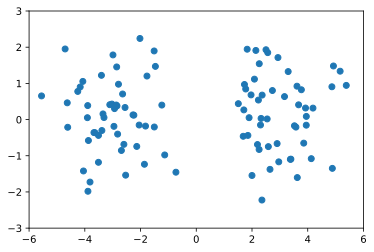

In [2]:
np.random.seed(0)
X = np.vstack([np.random.randn(50,2) + [-3,0], np.random.randn(50,2) + [3,0]])
plt.scatter(X[:,0], X[:,1])
plt.axis([-6,6,-3,3])

Even if you weren't to look at the code that generated these points, it should be fairly apparent that there are two different clusters of points here.   The goal of the k-means algorithm is to find a set of $k$ "centers" (that is, points $\mu^{(i)} \in \mathbb{R}^n$) such that every data point is close to at least one center.  By doing so, we can also associate each point with it's closest center, and use this as an indication of which cluster it belong to.  Let's see this graphically for our example above, using the knowledge that we generated the data to have two explicit clusters.

Text(3.1312784730135124, 0.032747468482162034, '$\\mu^{(2)}$')

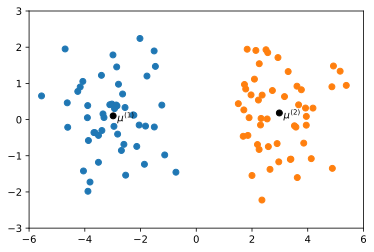

In [3]:
np.random.seed(0)
X = np.vstack([np.random.randn(50,2) + [-3,0], np.random.randn(50,2) + [3,0]])
mu1 = X[:50,:].mean(axis=0)
mu2 = X[50:,:].mean(axis=0)
plt.scatter(X[:50,0], X[:50,1], c='C0')
plt.scatter(X[50:,0], X[50:,1], c='C1')
plt.scatter(mu1[0], mu1[1], marker="o", c="k")
plt.scatter(mu2[0], mu2[1], marker="o", c="k")
plt.axis([-6,6,-3,3])
plt.text(mu1[0]+0.15, mu1[1]-0.15, "$\mu^{(1)}$")
plt.text(mu2[0]+0.15, mu2[1]-0.15, "$\mu^{(2)}$")


### Formal definition of the K-means algorithm

Let's see how this works in the formal setting we have described above.

**Hypothesis function** First let's discuss the hypothesis function.  The parameters $\theta$ of our hypothesis function just include the centers themselves
\begin{equation}
\theta = \{\mu^{(1)}, \ldots, \mu^{(k)}\}
\end{equation}
with each $\mu^{(i)} \in \mathbb{R}^n$ (note that, as will be a pattern from now on, we're still referring to _all_ the parameters of our hypothesis using the notation $\theta$, but more and more this will refer to a collection of parameters rather than just a single parameter vector).  Defined by these parameters, hypothesis function itself, $h_\theta(x)$, just _outputs the center than is closest to the point $x$_.  Written formally
\begin{equation}
\DeclareMathOperator*{argmin}{argmin}
h_\theta(x) = \argmin_{\mu \in \{\mu^{(1)}, \ldots, \mu^{(k)}\} } \|\mu - x\|_2^2
\end{equation}
where the $\argmin$ operator returns the argument that minimizes the expression (as opposed to the $\min$ operator which just returns the minimum value), i.e., the expression just outputs whichever center $\mu^{(1)},\ldots,\mu^{(k)}$ is closest to $x$.

**Loss function** The loss function used by k-means is simply the squared loss we mentioned earlier
\begin{equation}
\ell(h_\theta(x), x) = \|h_\theta(x) - x\|_2^2.
\end{equation}
Recalling that the hypothesis function simply outputs the closest mean to the given point $x$, this is equivalent to saying the loss for any point is simply the squared distance between the closest center and that point, i.e.,
\begin{equation}
\ell(h_\theta(x), x) = \min_{\mu \in \{\mu^{(1)}, \ldots, \mu^{(k)}\}} \|\mu - x\|_2^2.
\end{equation}

**Optimization** Finally, let's now consider the ML optimization problem that results from the hypothesis and loss above,
\begin{equation}
\minimize_\theta \;\; \frac{1}{m} \sum_{i=1}^m \min_{\mu \in \{\mu^{(1)}, \ldots, \mu^{(k)}\}} \|\mu - x^{(i)}\|_2^2.
\end{equation}
Unlike the settings we have seen before in supervised learning, in this case it is not standard to simply optimize this loss using gradient descent (though we emphasize that this _could_ be done).  Instead, a common strategy is to iteratively "assign" each point to its closest center (i.e., compute the term that achieves the $\min$ for each training point), then update each center to be the mean of these assigned points (this assignment is precisely the one that minimizes the loss assuming that center assignments are fixed), and repeat this process until convergence.  This is sometimes called Lloyd's algorithm, but more typically it just is referred to as "k-means", since it's the standard method for training k-means models.  There are many ways to initially assign cluster centers, but a common strategy is simply to choose $k$ of the data points at random.  Formally, the algorithm proceeds as follows.

<hr/>
**Algorithm**: K-means

**Given:** Data set $x^{(i)}, i=1,\ldots,m$

**Initialize:**
    
* $\mu^{(j)} := \mbox{RandomChoice}(x^{(1:m)}), \; j=1,\ldots,k$

**Repeat until convergence:**

* Assign point clusters: $y^{(i)} := \argmin_j \|\mu^{(j)} - x^{(i)}\|_2^2, \; i=1,\ldots,m$
* Compute new centers: $\displaystyle \mu^{(j)} := \sum_{i=1}^m \frac{x^{(i)} \mathrm{1}\{y^{(i)} = j\}}{\mathrm{1}\{y^{(i)} = j\}}, \;\; j=1,\ldots,k$

<hr/>

Although we won't prove this formally here, at each step the algorithm is guaranteed to _decrease_ the loss function (the intuition is that each step, both cluster re-assignment, and computing new centers, can only decrease the total loss, and so the overall loss will only decrease in this manner).  Further, because there are only a finite number of possible clusterings (exponentially large, of course, but still finite), we know the algorithm _will_ converge after a finite number of steps (i.e., the cluster assignments will stay constant from one iteration to the next, which means the centers will also not change, and the algorithm has reached a fixed point).

### Illustration of k-means

Let's see how this works in practice  The following is a reasonably efficient implementation of the algorithm. The key aspect that makes this efficient is that we compute the distances between all the points and all the centers using matrix operations (the same strategy was used previously when creating RBF features in our nonlinear classification setting).  For simplicity here we run the algorithm for a fixed number of iterations rather than checking for convergence explicitly.

In [4]:
def kmeans(X, k, max_iter=10, rand_seed=0):
    np.random.seed(rand_seed)
    Mu = X[np.random.choice(X.shape[0],k),:]
    for i in range(max_iter):
        D = -2*X@Mu.T + (X**2).sum(axis=1)[:,None] + (Mu**2).sum(axis=1)
        y = np.argmin(D,axis=1)
        Mu = np.array([np.mean(X[y==i],axis=0) for i in range(k)])
    loss = np.linalg.norm(X - Mu[np.argmin(D,axis=1),:])**2/X.shape[0]
    return Mu, y, loss

The first line randomly assigns centers to $k$ of the data points.  We then repeat for `max_iter` iterations, each time:

1. Computing the distance between all points and all clusters, `D`
2. Computing the cluster assignment of each point, `y`
3. Recomputing the centers to be the average of their points

We finally return these clusters plus the squared loss itself.

Lets see how this looks on a three-cluster example.  Our synthetic data will be generated from three different clusters.

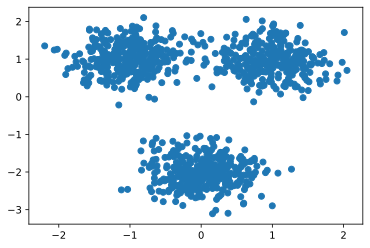

In [5]:
X = m,n = (1000,2)
np.random.seed(0)
X = 0.4*np.random.randn(m,n)
Mu0 = np.array([[0,-2], [-1,1], [1,1]])
X += Mu0[np.random.choice(np.arange(3), m),:]
plt.scatter(X[:,0], X[:,1])

We'll also extend the code above for this particular example to plot the cluster means at their assignments at each iteration of the algorithm.

In [6]:
colors = np.array(["C0", "C1", "C2"])
def kmeans_visualize(X, k, max_iter=10, rand_seed=0):
    f,ax = plt.subplots(max_iter, figsize=(6.0, 4.6*max_iter))
    np.random.seed(rand_seed)
    Mu = X[np.random.choice(X.shape[0],k),:]
    for i in range(max_iter):
        D = -2*X@Mu.T + (X**2).sum(axis=1)[:,None] + (Mu**2).sum(axis=1)
        y = np.argmin(D,axis=1)
        ax[i].scatter(X[:,0], X[:,1], c=colors[y])
        ax[i].scatter(Mu[:,0], Mu[:,1], c='k')
        
        Mu = np.array([np.mean(X[y==i],axis=0) for i in range(k)])
    loss = np.linalg.norm(X - Mu[np.argmin(D,axis=1),:])**2/X.shape[0]
    return Mu, y, loss

Let's run this on our simple three-cluster setting.  Here we show the first four iterations of the algorithm, after which time it is already converged.

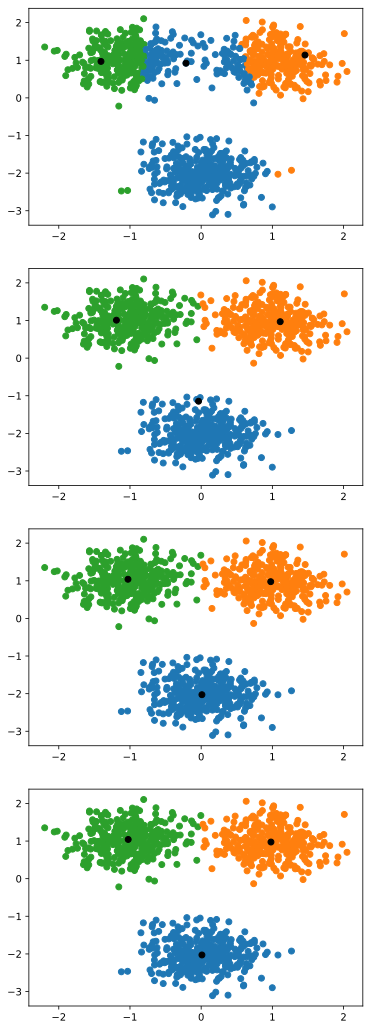

In [7]:
kmeans_visualize(X, 3, max_iter=4, rand_seed = 3);

However, note that k-means is particularly susceptible to getting stuck in local optima.  For example, with a different random initialization, we may get the following behavior instead.

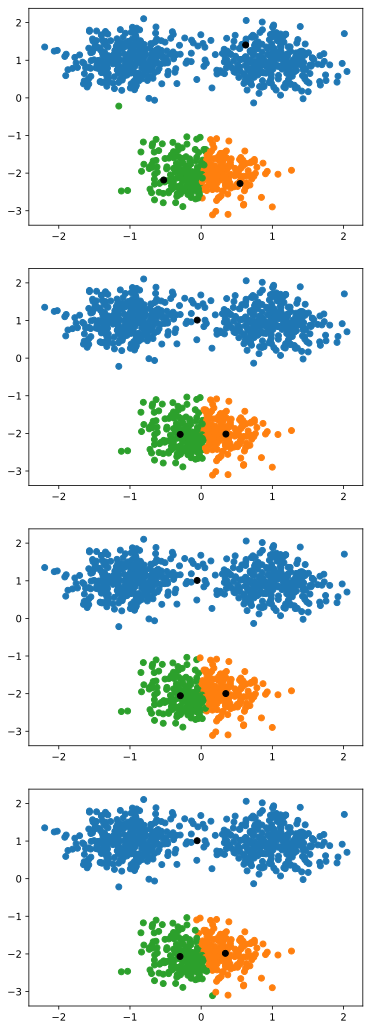

In [8]:
kmeans_visualize(X, 3, max_iter=4, rand_seed=13);

### K-means++

To counteract the possibility of local optima, there are a number of schemes for initializing the centers of the k-means algorithm.  One of the most popular strategies is the [k-means++ algorithm](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf).  The basic idea of this approach is that instead of simply choosing the centers to be random points, we sample the initial centers iteratively, each time putting higher probability on points that are _far_ from any existing center.  Formally, the algorithm proceeds as follows.


<hr/>
**Algorithm**: K-means++

**Given:** Data set $x^{(i)}, i=1,\ldots,m$

**Initialize:**
    
* $\mu^{(1)} := \mbox{RandomChoice}(x^{(1:m)})$

**For $j=2,\ldots,k$**

* Computing probabilities of selecting each point
\begin{equation}
p^{(i)} = \frac{\min_{j'<j} \|\mu^{(j')} - x^{(i)}\|_2^2}{\sum_{i'=1}^m \min_{j'<j} \|\mu^{(j')} - x^{(i')}\|_2^2}
\end{equation}
* Select next center given the appropriate probabilities
\begin{equation}
\mu^{(j)} := \mbox{RandomChoice}(x^{(1:m)}, p^{(1:m)})
\end{equation}

<hr/>

You'll implement this algorithm in your homework, so we don't include it here, but essentially, because we select points based upon how far they are from any existing center, the chance of a "bad" initialization like the one we saw above is very low.  Once we have initialized the centers in this manner, we run the k-means algorithm as normal.

### Selecting $k$

One obvious question that arises with this method is: how do we choose hyperparameters for the k-means++ algorithm, such as the number of centers $k$?  Much like in supervised learning, there is no way to directly assess this from the training loss itself; modulo the possibility of local optima, the loss should continue to decrease for larger numbers of centers (the more centers, the closer any given point will be to them).  But unlike supervised learning, there is not even a good analogue of cross-validation that we can use here: this property of lower loss will typically _also_ apply to a validation set as well.

For this reason, the process of selecting the number of clusters is typically an imprecise art, and it is _very_ difficult to infer anything about the "real" number of clusters in the data from running k-means (in fact, you should really never try to do this).  A common strategy is rather just to plot the loss versus the number of clusters and try to find a point that is "good enough" in terms of loss versus the number of cluster (i.e., where adding additional clusters doesn't help much).

Let's do this first on our synthetic examples.

Text(0, 0.5, 'Average loss')

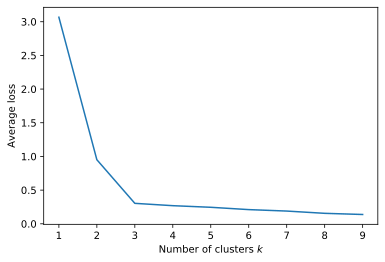

In [9]:
losses = [kmeans(X,k,max_iter=10,rand_seed=0)[2] for k in range(1,10)]
plt.plot(range(1,10), losses)
plt.xlabel("Number of clusters $k$")
plt.ylabel("Average loss")

In this case, it seems reasonable to choose 3 clusters, as the loss decreases quite rapidly to that point, and only decreases slowly after that.  But again, we'll emphasize that except in extremely contrived examples like this (where there really are a small number of clusters generating the data), it is almost never possible to determine the "true" number of clusters from such analysis.

### Example: handwritten digits

As as example, let's consider the task of clustering images of handwritten digits from the MNIST data set.  This data set has been used extensively as a benchmark in the ML community, to the extent that it actually isn't that instructive when it comes to the task of e.g. actual digit recognition at this point, but it still serves as a nice graphical illustration of a technique like k-means.  We can gather this data using one of the scikit learn built in functions.

In [11]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

ImportError: cannot import name 'fetch_mldata' from 'sklearn.datasets' (/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/datasets/__init__.py)

The data looks like the following.

In [ ]:
dat = mnist.data[np.random.choice(mnist.data.shape[0],50)]
def plot_mnist(dat, M, N):
    digits = np.vstack([np.hstack([np.reshape(dat[i*N+j,:],(28,28)) 
                                   for j in range(N)]) for i in range(M)])
    plt.imshow(255-digits, cmap="gray")
    plt.xticks([])
    plt.yticks([])
plot_mnist(dat, 5, 10)

Let's run k-means with 30 centers on this data set, and plot the resulting centers (remember, these centers are averaging together images, so the centers themselves will look like reasonable images).

In [ ]:
Mu, y, l = kmeans(mnist.data, 30, max_iter=10, rand_seed=0)
plot_mnist(Mu,5,6)

Again, though, we should emphasize that this is a very bad method for "inferring" the number of true clusters in the data (which in this case case is 10 different images).  Let's see what happens when we try to run k-means with 10 clusters.

In [ ]:
Mu, y, l = kmeans(mnist.data, 10, max_iter=10, rand_seed=0)
plot_mnist(Mu,2,5)

The "5" seems to be mostly missing (possibly combined with the "3", and there is some mix of "4", "7", "9" characters.  If we were to look at the loss over the number of clusters.  Essentially, what happened in our example with some centers being contained within a single class, while others are spread over multiple classes, is exactl what is happening here.  A better initialization like k-means++ and running for more iterations can help a little bit, but doesn't fix the fundamental problem.  Rather, what's happening is simply the fact that in the pixel space of these images, it isn't neccessarily the case that the different images cluster as we would like: a "1" could be much closer in image distance to some "7" than to another "1".

We can plot the loss over the different number of clusers

In [ ]:
losses = [kmeans(mnist.data, k, max_iter=10, rand_seed=0)[2] for k in range(1,20)]
plt.plot(range(1,20), losses)

We would definitely not be able to tell there were 10 actual classes just by looking at this plot.  The take-home messsage here is that if anyone tries to claim that they ran k-means (or really most any clustering algorithm) to determine that there "are" X number of clusters in the data, you should be skeptical.  Most likely they simply ran a clustering algorithm _with_ X clusters, and the algorithm happily obliged.